### Vanishing / Exploding gradients

solving:
+ ReLu
+ Leaky ReLu
+ ELu
+ Batch Normalization
+ Gradient Clipping during backpropagation so that they never exceed some threshold (mostly useful for RNN)

Derivative of simgoid function: $f(x)=f(x) * (1 - f(x))$

In [85]:
z.shape

(200,)

In [88]:
def sigmoid(z):
    return 1 / (1+np.exp(-z))

def de_sigmoid(z):
    return sigmoid(z) * (1 - (sigmoid(z)))

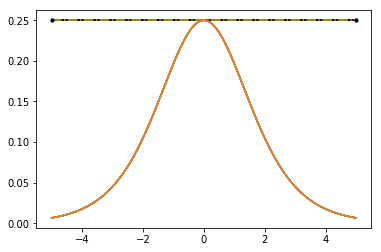

In [101]:
plt.plot(z, de_sigmoid(z))
plt.plot([-5, 5], [0.25, 0.25], 'k.')
plt.show(0)

深度神经网络中参数更新需要用到 Derivative(simgoid), 从图中可以看到最大值为0.25，随着层数的增加，乘积会越来越小，会发生梯度消失问题。

### ReLU

In [105]:
def relu(z):
    return np.where(z < 0, 0, z)

def de_relu(z):
    return np.where(z < 0, 0, 1)

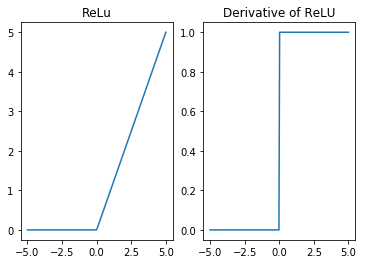

In [107]:
z = np.linspace(-5, 5, 200)

plt.subplot(121); plt.plot(z, relu(z)); plt.title("ReLu")
plt.subplot(122); plt.plot(z, de_relu(z)); plt.title("Derivative of ReLU")
plt.show()

ReLU优势：
+ 解决了梯度消失问题；
+ 加快训练速度.

缺点：
+ $z < 0$时值为0，梯度还是会消失

# Xavier and He Initialization

In [1]:
import tensorflow as tf

In [2]:
n_inputs = 28*28
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [3]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                         kernel_initializer=he_init, name="hidden1")

# Nonsaturating Activation Functions

ReLU activation function is not perfect. 

### Leaky ReLU

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [13]:
reset_graph()

In [77]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

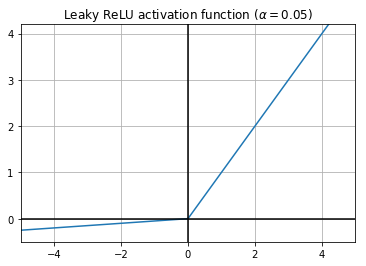

In [78]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -0.5, 4.2])
plt.title(r"Leaky ReLU activation function ($\alpha=0.05$)")
plt.show()

In [15]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

In [45]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [46]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [47]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [48]:
from tensorflow.contrib.layers import fully_connected

In [49]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [50]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [51]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [52]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

load mnist datasets.

In [14]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [15]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255
y_train = y_train.astype(np.int32)
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [12]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [56]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy", acc_batch, "Validation accuracy", acc_valid)

0 Batch accuracy 0.86 Validation accuracy 0.9044
1 Batch accuracy 0.92 Validation accuracy 0.9226
2 Batch accuracy 0.94 Validation accuracy 0.9324
3 Batch accuracy 0.92 Validation accuracy 0.9392
4 Batch accuracy 0.94 Validation accuracy 0.9464
5 Batch accuracy 0.94 Validation accuracy 0.9496
6 Batch accuracy 1.0 Validation accuracy 0.956
7 Batch accuracy 0.96 Validation accuracy 0.957
8 Batch accuracy 0.96 Validation accuracy 0.9606
9 Batch accuracy 0.92 Validation accuracy 0.961
10 Batch accuracy 0.92 Validation accuracy 0.9654
11 Batch accuracy 0.98 Validation accuracy 0.9668
12 Batch accuracy 0.98 Validation accuracy 0.968
13 Batch accuracy 0.96 Validation accuracy 0.9688
14 Batch accuracy 1.0 Validation accuracy 0.9704
15 Batch accuracy 0.94 Validation accuracy 0.971
16 Batch accuracy 1.0 Validation accuracy 0.9726
17 Batch accuracy 1.0 Validation accuracy 0.973
18 Batch accuracy 0.98 Validation accuracy 0.9742
19 Batch accuracy 0.96 Validation accuracy 0.9748


### ELU

In [57]:
reset_graph()

In [58]:
from tensorflow.contrib.layers import fully_connected

np.where(condition, x, y)

if (condition):
    return x;
else:
    return y;

In [59]:
def elu(x, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

In [60]:
z = np.linspace(-5, 5, 200)

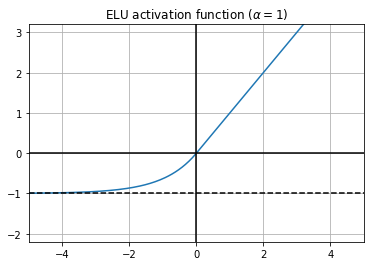

In [80]:
plt.plot(z, elu(z))
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.axis([-5, 5, -2.2, 3.2])
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)")
plt.show()

In [82]:
reset_graph()

In [108]:
hidden1 = fully_connected(X, n_hidden1, activation_fn=tf.nn.relu)

# Batch Normalization

The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer.

Four parameters are learned for each batch-normalized layer: $\gamma$(scale), $\beta$(offset), $\mu$(mean), and $\delta$(standard deviation)

Advantages:
+ The vanishing gradients problem was strongly reduced;
+ less sensitive to the weights initialization;
+ can use much larger learning rates;
+ also acts like a regularizerm reducing the need for other regularization techiques(such as dropout).

Disadvantages:
+ make slower predictions due to the extra computations required at each layer.

In [111]:
reset_graph()

import tensorflow as tf

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name="training")

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, 
                                      momentum=0.9)

`batch_normalization()`:
+ `training`:
    + `True` (during training), use the current mini-batch's mean and standard deviation;
    + `False` (during testing), the running averages that is keeps track of.

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [132]:
from functools import partial

In [131]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

my_batch_normal_layzer = partial(tf.layers.batch_normalization,
                                training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_normal_layzer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2,name="hidden2")
bn2 = my_batch_normal_layzer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn= tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_normal_layzer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [141]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    my_dense_layer = partial(tf.layers.dense, 
                             kernel_initializer=he_init)
    
    my_batch_norm_layer = partial(tf.layers.batch_normalization,
                                  training=training, 
                                  momentum=batch_norm_momentum)
    
    hidden1 = my_dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    
    hidden2 = my_dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    
    logits_before_bn = my_dense_layer(bn2, n_outputs, name="outputs")
    logits = my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [142]:
n_epochs = 20
batch_size = 200

In [144]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], 
                    feed_dict={training: True, X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

0 Validation accuracy 0.8942
1 Validation accuracy 0.9186
2 Validation accuracy 0.93
3 Validation accuracy 0.9426
4 Validation accuracy 0.9468
5 Validation accuracy 0.9534
6 Validation accuracy 0.9562
7 Validation accuracy 0.9594
8 Validation accuracy 0.9614
9 Validation accuracy 0.965
10 Validation accuracy 0.9658
11 Validation accuracy 0.9662
12 Validation accuracy 0.968
13 Validation accuracy 0.9706
14 Validation accuracy 0.9706
15 Validation accuracy 0.9716
16 Validation accuracy 0.972
17 Validation accuracy 0.9728
18 Validation accuracy 0.9734
19 Validation accuracy 0.9748


Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```

In [146]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [147]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

# Gradient Clipping 
during backpropagation so that they never exceed some threshold (mostly useful for RNN).

In [5]:

import tensorflow as tf
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [6]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the clip_by_value() function to clip them, then apply them:

In [7]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
             for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

As usual

In [8]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [9]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
n_epochs = 20
batch_size = 50

In [16]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.8768
1 Validation accuracy 0.9276
2 Validation accuracy 0.9456
3 Validation accuracy 0.9546
4 Validation accuracy 0.9574
5 Validation accuracy 0.9556
6 Validation accuracy 0.9672
7 Validation accuracy 0.9714
8 Validation accuracy 0.9678
9 Validation accuracy 0.9722
10 Validation accuracy 0.9746
11 Validation accuracy 0.9744
12 Validation accuracy 0.9702
13 Validation accuracy 0.972
14 Validation accuracy 0.9766
15 Validation accuracy 0.976
16 Validation accuracy 0.9758
17 Validation accuracy 0.9756
18 Validation accuracy 0.9776
19 Validation accuracy 0.9744


# Reusing Pretrained Layers

In [17]:
reset_graph()

In [18]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

In [19]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read
hidden2/bias/Initializer/zeros
hidden2/bias
hidden2/bias/Assign
hidden2/bias/read
dn

In [21]:
file_writer = tf.summary.FileWriter("./tf_logs/11/", tf.get_default_graph())

In [31]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/Mean:0")

training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

In [33]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [34]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9788
1 Validation accuracy: 0.9776
2 Validation accuracy: 0.976
3 Validation accuracy: 0.9786
4 Validation accuracy: 0.9766
5 Validation accuracy: 0.9788
6 Validation accuracy: 0.978
7 Validation accuracy: 0.9786
8 Validation accuracy: 0.9788
9 Validation accuracy: 0.9786
10 Validation accuracy: 0.9786
11 Validation accuracy: 0.9786
12 Validation accuracy: 0.9774
13 Validation accuracy: 0.9778
14 Validation accuracy: 0.979
15 Validation accuracy: 0.978
16 Validation accuracy: 0.9776
17 Validation accuracy: 0.9794
18 Validation accuracy: 0.9782
19 Validation accuracy: 0.9788


# Reusing a Tensorflow Model


In [36]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [39]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)        # to restore layers 1-3

init = tf.global_variables_initializer()

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)
    
    saver_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy 0.9752
1 Validation accuracy 0.9764
2 Validation accuracy 0.9768
3 Validation accuracy 0.978
4 Validation accuracy 0.9766
5 Validation accuracy 0.9792
6 Validation accuracy 0.9768
7 Validation accuracy 0.9758
8 Validation accuracy 0.9768
9 Validation accuracy 0.9776
10 Validation accuracy 0.9762
11 Validation accuracy 0.9782
12 Validation accuracy 0.9794
13 Validation accuracy 0.978
14 Validation accuracy 0.9762
15 Validation accuracy 0.9776
16 Validation accuracy 0.9738
17 Validation accuracy 0.9774
18 Validation accuracy 0.9796
19 Validation accuracy 0.9782


# Reusing Models from Other Frameworks

In [45]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, tf.nn.relu, name="hidden1")

with tf.variable_scope("", default_name="", reuse=True):
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")
    
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=(n_hidden1))

assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    print(hidden1.eval(feed_dict={X: [[10., 11.]]}))

[[ 61.  83. 105.]]


In [46]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

In [49]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [50]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

# Freezing the Lower Layers

In [62]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss =  tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [64]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                     scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=training_vars)

In [66]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy 0.9642
1 Validation accuracy 0.972
2 Validation accuracy 0.9738
3 Validation accuracy 0.975
4 Validation accuracy 0.9764
5 Validation accuracy 0.977
6 Validation accuracy 0.9768
7 Validation accuracy 0.9776
8 Validation accuracy 0.9758
9 Validation accuracy 0.978
10 Validation accuracy 0.9764
11 Validation accuracy 0.9766
12 Validation accuracy 0.9772
13 Validation accuracy 0.9766
14 Validation accuracy 0.977
15 Validation accuracy 0.9772
16 Validation accuracy 0.976
17 Validation accuracy 0.977
18 Validation accuracy 0.9764
19 Validation accuracy 0.976


In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [73]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, 
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, 
                              name="hidden2") # reused frozen
    
    hidden2_stop = tf.stop_gradient(hidden2)
    
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, 
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, 
                              name="hidden4") # new !
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new !

In [74]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [76]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy 0.9668
1 Validation accuracy 0.9716
2 Validation accuracy 0.9742
3 Validation accuracy 0.9748
4 Validation accuracy 0.9756
5 Validation accuracy 0.9772
6 Validation accuracy 0.9754
7 Validation accuracy 0.9758
8 Validation accuracy 0.9766
9 Validation accuracy 0.9772
10 Validation accuracy 0.976
11 Validation accuracy 0.9768
12 Validation accuracy 0.9772
13 Validation accuracy 0.9756
14 Validation accuracy 0.9764
15 Validation accuracy 0.977
16 Validation accuracy 0.9754
17 Validation accuracy 0.9756
18 Validation accuracy 0.9764
19 Validation accuracy 0.9758


# Cathing the Frozen Layers

In [90]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, 
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, 
                              name="hidden2") # reused frozen & cathed
    
    hidden2_stop = tf.stop_gradient(hidden2)
    
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, 
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, 
                              name="hidden4") # new !
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new !
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 100
n_batches = 500

with tf.Session() as sess:
    sess.run(init)
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cathe = sess.run(hidden2, feed_dict={X: X_train})
    h2_cathe_valid = sess.run(hidden2, feed_dict={X: X_valid})
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cathe, n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2: hidden2_batch, y: y_batch})
            
        acc_val = accuracy.eval(feed_dict={hidden2: h2_cathe_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy 0.1234
1 Validation accuracy 0.0838
2 Validation accuracy 0.0766
3 Validation accuracy 0.0862
4 Validation accuracy 0.1364
5 Validation accuracy 0.1342
6 Validation accuracy 0.1192
7 Validation accuracy 0.1236
8 Validation accuracy 0.1236
9 Validation accuracy 0.1178
10 Validation accuracy 0.1152
11 Validation accuracy 0.114
12 Validation accuracy 0.1136
13 Validation accuracy 0.1138
14 Validation accuracy 0.1134
15 Validation accuracy 0.1136
16 Validation accuracy 0.1136
17 Validation accuracy 0.1134
18 Validation accuracy 0.1132
19 Validation accuracy 0.1128
20 Validation accuracy 0.1128
21 Validation accuracy 0.1128
22 Validation accuracy 0.1128
23 Validation accuracy 0.1128
24 Validation accuracy 0.1128
25 Validation accuracy 0.1132
26 Validation accuracy 0.1134
27 Validation accuracy 0.1132
28 Validation accuracy 0.1132
29 Validation accuracy 0.1128
30 Validation accuracy 0.1128
31 Validation acc

# Faster Optimizers


### Momentum optimization

In [93]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                      momentum=0.9)

### NAG

In [94]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                      momentum=0.9, use_nesterov=True)

# Learning Rate Scheduling

In [120]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [125]:
with tf.name_scope("train"):       
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                               decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

Exponential scheduling

$\eta(t) = \eta_010^{-t/r}$

where:
+ $t$ is the iteration number;
+ $\eta_0=0.1$, decay_rate;
+ $r=10000$, decay_steps.

In [126]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

0 Validation accuracy 0.96
1 Validation accuracy 0.9736
2 Validation accuracy 0.977
3 Validation accuracy 0.9802
4 Validation accuracy 0.981


# Avoiding Overfitting Through Regularization

### $l_1$ and $l_2$ Regularization

In [129]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

$L_1 $regularizer: $S = \sum_{i=1}^n|y_i-f(x_i)|$ 

$L_2 $regularizer: $S = \sum_{i=1}^n(y_i-f(x_i))^2$ 

In [134]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.01  # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                              logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_entropy")
    reg_loss = tf.reduce_sum(tf.abs(W1) + tf.reduce_sum(tf.abs(W2)))
    loss = tf.add(base_loss, scale * reg_loss, name="loss")

In [139]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()

n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.36
1 Validation accuracy: 0.0154
2 Validation accuracy: 0.243
3 Validation accuracy: 0.0596
4 Validation accuracy: 0.1218
5 Validation accuracy: 0.11
6 Validation accuracy: 0.1168
7 Validation accuracy: 0.1126
8 Validation accuracy: 0.1126
9 Validation accuracy: 0.1126
10 Validation accuracy: 0.1126
11 Validation accuracy: 0.1126
12 Validation accuracy: 0.1126
13 Validation accuracy: 0.1126
14 Validation accuracy: 0.1126
15 Validation accuracy: 0.1126
16 Validation accuracy: 0.1126
17 Validation accuracy: 0.1126
18 Validation accuracy: 0.1126
19 Validation accuracy: 0.1126


### Dropout

In [141]:
reset_graph()

In [142]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [143]:
training = tf.placeholder_with_default(False, shape=(), name="training")

keep_prob = 0.5 
X_drop = tf.layers.dropout(X, keep_prob, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                              name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, keep_prob, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, 
                              name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, keep_prob, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [146]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

0 Validation accuracy 0.879
1 Validation accuracy 0.9082
2 Validation accuracy 0.9234
3 Validation accuracy 0.934
4 Validation accuracy 0.9396
5 Validation accuracy 0.9442
6 Validation accuracy 0.9462
7 Validation accuracy 0.9538
8 Validation accuracy 0.953
9 Validation accuracy 0.958
10 Validation accuracy 0.9598
11 Validation accuracy 0.9628
12 Validation accuracy 0.9596
13 Validation accuracy 0.9636
14 Validation accuracy 0.9644
15 Validation accuracy 0.964
16 Validation accuracy 0.9658
17 Validation accuracy 0.9662
18 Validation accuracy 0.9664
19 Validation accuracy 0.9678


### MAX-Norm Regularization

In [147]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [153]:
threshold = 1.
weights1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights1 = tf.clip_by_norm(weights1, clip_norm=threshold, axes=1)
clip_weights1 = tf.assign(weights1, clipped_weights1)

In [154]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

In [155]:
init= tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights1.eval()
            clip_weights2.eval()
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", acc_val)

0 Validation accuracy 0.9244
1 Validation accuracy 0.9456
2 Validation accuracy 0.9528
3 Validation accuracy 0.9628
4 Validation accuracy 0.9656
5 Validation accuracy 0.9682
6 Validation accuracy 0.9718
7 Validation accuracy 0.9734
8 Validation accuracy 0.974
9 Validation accuracy 0.9766
10 Validation accuracy 0.9778
11 Validation accuracy 0.9764
12 Validation accuracy 0.9782
13 Validation accuracy 0.9778
14 Validation accuracy 0.979
15 Validation accuracy 0.9776
16 Validation accuracy 0.9794
17 Validation accuracy 0.98
18 Validation accuracy 0.9808
19 Validation accuracy 0.9804


In [157]:
reset_graph()

In [158]:
def max_norm_regularizer(threshold, axes=1, name="max_norm",
                        collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        return None
    return max_norm

In [159]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [160]:
max_norm_reg = max_norm_regularizer(threshold=1.)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                             kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                             kernel_regularizer=max_norm_reg, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [163]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "Validation accuracy:", acc_valid)

0 Validation accuracy: 0.9238
1 Validation accuracy: 0.9408
2 Validation accuracy: 0.9504
3 Validation accuracy: 0.9588
4 Validation accuracy: 0.9632
5 Validation accuracy: 0.9662
6 Validation accuracy: 0.9712
7 Validation accuracy: 0.9724
8 Validation accuracy: 0.974
9 Validation accuracy: 0.9746
10 Validation accuracy: 0.9756
11 Validation accuracy: 0.9738
12 Validation accuracy: 0.9772
13 Validation accuracy: 0.9782
14 Validation accuracy: 0.978
15 Validation accuracy: 0.9792
16 Validation accuracy: 0.979
17 Validation accuracy: 0.9794
18 Validation accuracy: 0.979
19 Validation accuracy: 0.9776


# Exercises

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [9]:
n_inputs = 28 * 28
n_hidden1 = 100
n_hidden2 = 100
n_hidden3 = 100
n_hidden4 = 100
n_hidden5 = 100
n_outputs = 5

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [16]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

he_init = tf.variance_scaling_initializer()
training = tf.placeholder_with_default(False, shape=(), name="training")

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
       initializer=he_init, training=training):
    with tf.name_scope("dnn"):
        for i in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons,
                                    kernel_initializer=initializer, 
                                     name="hidden{}".format(i+1))
            bn = tf.layers.batch_normalization(inputs, training=training,
                                                   momentum=0.9)
            bn_drop = tf.layers.dropout(bn, 0.5, training=training)
            inputs = tf.nn.elu(bn_drop)
        return inputs

hidden = dnn(X)
logits = tf.layers.dense(hidden, n_outputs, name="outputs")
y_proba = tf.nn.softmax(logits, name="y_proba")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, 
                                                           logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="eval")
    
learning_rate = 0.01
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss, name="train")

In [17]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [19]:
n_epochs = 1000
batch_size = 20

best_loss = np.infty
checks_without_progress = 0
max_checks_without_progress = 20

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for rnd_idx in np.array_split(np.random.permutation(len(X_train1)),
                                     len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_idx], y_train1[rnd_idx]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./exercises/11/my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

0	Validation loss: 0.100951	Best loss: 0.100951	Accuracy: 97.58%
1	Validation loss: 0.115543	Best loss: 0.100951	Accuracy: 96.91%
2	Validation loss: 0.078686	Best loss: 0.078686	Accuracy: 98.40%
3	Validation loss: 0.079974	Best loss: 0.078686	Accuracy: 98.48%
4	Validation loss: 0.070548	Best loss: 0.070548	Accuracy: 98.28%
5	Validation loss: 0.085883	Best loss: 0.070548	Accuracy: 98.51%
6	Validation loss: 0.076955	Best loss: 0.070548	Accuracy: 98.36%
7	Validation loss: 0.115555	Best loss: 0.070548	Accuracy: 96.72%
8	Validation loss: 0.065526	Best loss: 0.065526	Accuracy: 98.55%
9	Validation loss: 0.055824	Best loss: 0.055824	Accuracy: 98.67%
10	Validation loss: 0.065460	Best loss: 0.055824	Accuracy: 98.44%
11	Validation loss: 0.204806	Best loss: 0.055824	Accuracy: 97.97%
12	Validation loss: 0.047918	Best loss: 0.047918	Accuracy: 98.87%
13	Validation loss: 0.075924	Best loss: 0.047918	Accuracy: 98.20%
14	Validation loss: 0.074461	Best loss: 0.047918	Accuracy: 98.51%
15	Validation loss: 

In [7]:
save_log = tf.summary.FileWriter("./tf_logs/11/", tf.get_default_graph())